In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# 8 Optimization Methods

## 8.1 Gradient Descent
- Application: Gradient descent is used to estimate the parameters of a model, in particular coefficients in linear regression or weights in neural networks
- Description: Gradient descent is an iterative optimization algorithm for finding the minimum of a (loss) function and the model parameters that minimize that (loss) function
- Functionality:
    * The cost function is a quadratic and most of the time convex function, meaning it has one global minimum
    * First step is to find the gradient, which is the first partial derivative of the cost function ($\frac{\delta}{\delta\theta_j}J(\theta)$), and initialize the model parameters $\theta$ at random
    * In order to find the cost function's minimum we move to the negative of the gradient; those moves will be big in the beginning and become smaller as the gradient approaches 0 (the minimum of the cost function)
    * We also introduce a learning rate $\alpha$ that scales the impact of the gradient on $\theta$; we can have the learning rate gradually decrease towards the end of the iterations to avoid overshooting the minimum
    * After each move, we adjust $\theta$ by the negatige gradient adjusted by the learning rate
    * The gradient descent can hence be formalized as: $\theta_j := \theta_j - \alpha \frac{\delta}{\delta\theta_j}J(\theta)$
    * There are different variants of the gradient descent:
        * Batch: Compute gradient in one-shot with all training data; disadvantage: very memory expensive especially for large datasets
        * Stochastic: Compute gradient using one random training data instance at a time
        * Mini-batch: Compute gradient using specified number (mini-batch size) of random training data instances
- Limitations: We don't always arrive at the true minimum, however the advantage of this approach is that we don't have to calculate the second derivative or inverse, making it faster than the normal equation of Hessian when the amount of features is very large

In [202]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

In [207]:
# load data
boston = load_boston()
features = pd.DataFrame(boston["data"], columns = boston["feature_names"])
y = np.asarray(boston["target"])
x = np.asarray(features[["RAD", "ZN", "CRIM", "AGE"]].values)

# initiate StandardScaler()
scaler = StandardScaler()

# fit scaler with training data
x = scaler.fit_transform(x)

# add a column of 1s for intercept
ones_x = np.ones((len(x), 1))
x_new = np.append(ones_x, x, axis = 1)

# initialize values for gradient descent
eta = 0.1
n_iterations = 1000
m = len(x)
theta = np.random.randn(5,1)

# run gradient descent
for iteration in range(n_iterations):
    gradients = 2/m * x_new.T.dot(x_new.dot(theta) - [[i] for i in y])
    theta = theta - eta * gradients
    
# print results
print("The betas for the model are: {}".format(np.around([i[0] for i in theta][1:], decimals = 2)))
print("The interception for the model is: {}".format(np.around([i[0] for i in theta][0], decimals = 2)))

The betas for the model are: [-1.07  1.9  -2.11 -1.15]
The interception for the model is: 22.53


## 8.2 Newton-Raphson
- Application: Newton-Rapshon is applied to approximate roots of a function (i.e. Log-Likelihood function)
- Description: Newton-Raphson method approximates $f(x)$ with Taylor expansion in the vicinity of the previous iteration
- Functionality:
    * We choose an intitial value $x_0$ for the algorithm
    * We write and adjust the Taylor expansion to be: $x_{i+1} = x_i - \frac{f(x_i)}{f'(x_i)}$
    * We check the stopping condition $|x_{i+1} - x_i| \leq \epsilon$, where $\epsilon$ is a preselected small number
    
<img src="https://media.geeksforgeeks.org/wp-content/cdn-uploads/newtonRaphsonMethod.png"
     width="500" height="300" />   
- Limitations: This method requires the derivative of the original function, which can be very complicated. Also the initial guess needs to be fairly accurate

The two roots are -0.81 and 2.47.


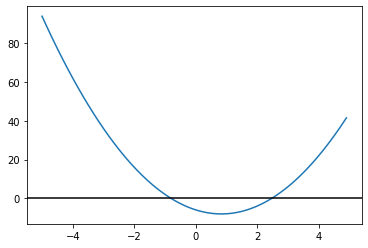

In [101]:
# define newton raphson optimizer
def newton_raphson(start_value, input_function, epsilon):
    x0 = start_value
    x1 = x0 - (input_function(x0) / ((input_function(x0 + 0.0000001) - input_function(x0)) / (0.0000001)))
    while (abs(x1 - x0) > epsilon):
        x0 = x1
        x1 = x0 - (input_function(x0) / ((input_function(x0 + 0.0000001) - input_function(x0)) / (0.0000001)))
    return x1

# create test function
def test_func(x_input):
    return x_input**2 * 3 - x_input*5 - 6

# plot test function
x = np.arange(-5, 5, 0.1)
plot = plt.plot(x, [test_func(i) for i in x])
plot = plt.axhline(y=0, color='k')

# calculate roots
print('The two roots are {:.2f} and {:.2f}.'.format(newton_raphson(-2, test_func, 0.00001), newton_raphson(2, test_func, 0.00001)))

## 8.3 Grid Search for Hyperparameter Optimization
- Application: Grid Search is used to find the optimal hyperparameters of a model which results in the most accurate predictions
- Description:
    * Parameters: Internal characteristic of a model, meaning it can be estimated from the data (i.e. beta coefficients for linear regression)
    * Hyperparameters: Characteristic of a model that is external, meaning it cannot be estimated from the data. The hyperparameter needs to be determined when fitting the model (i.e. k for KNN)

In [8]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [124]:
# load data
iris = load_iris()
iris = pd.concat([pd.DataFrame(iris['data'], columns = ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]), pd.DataFrame(iris['target'], columns = ['Species'])],
                axis = 1)
y = iris['Species']
x = iris[["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]].values

# initialize models
models = {'dt': DecisionTreeClassifier(), 'rf': RandomForestClassifier(), 'gb': GradientBoostingClassifier()}

# set parameters for each model
params = {'dt' : {'criterion':('gini', 'entropy'), 'max_depth':[5,7,9,11,13,15,None], 'max_leaf_nodes':list(range(10,100,5))},
          'rf': {'criterion':('gini', 'entropy'), 'max_depth':[5,7,9,11,13,15,None], 'max_leaf_nodes':list(range(10,100,5))},
          'gb': {'max_depth':[5,7,9,11,13,15,None], 'max_leaf_nodes':list(range(10,100,5))}}
          
# run grid search for each model
def fit(x_train, y_train):
    """
    fits the list of models to the training data, thereby obtaining in each case an evaluation score after GridSearchCV cross-validation
    """
    for name in models.keys():
        est = models[name]
        est_params = params[name]
        gscv = GridSearchCV(estimator = est, param_grid = est_params, cv = 5)
        gscv.fit(x_train, y_train)
        print("best parameters are: {}".format(gscv.best_estimator_))

# apply function
fit(x, y)

best parameters are: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
best parameters are: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=40,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
best parameters are: GradientBoostingClassifier(criterion='friedman_mse',